In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

In [2]:
df1 = pd.read_csv(r"D:\desktop\B\数据\标准化后数据\df1.csv")
df2 = pd.read_excel(r"D:\desktop\B\数据\标准化后数据\df2.xlsx")


In [3]:
selected_features = ["CONS", "LDH", "MV", "AST", "CRRT", "U", "L", "HR", "D.Dimer", "CR", "age", "ALT"]
target = 'mort'
X = df1[selected_features]
y = df1[target]
X_train, X_internal_test, y_train, y_internal_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_external_test = df2[selected_features]
y_external_test = df2[target]

In [4]:
import numpy as np
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
RANDOM_SEED=42
# 定义计算置信区间的函数
def bootstrap_metric_ci(y_true, y_pred, metric_func, n_bootstraps=10000, ci=95, random_state=42):
    rng = np.random.RandomState(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    bootstrapped_scores = []
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=rng)
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    lower_bound = np.percentile(bootstrapped_scores, (100-ci)/2)
    upper_bound = np.percentile(bootstrapped_scores, 100-(100-ci)/2)
    return lower_bound, upper_bound

# 定义参数网格
params_ann = {
    'activation': ['relu'],  # 选择 relu，减少搜索空间
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # 添加较小的网络结构
    'solver': ['adam'],  # 保持 adam 优化器
    'alpha': [0.001, 0.01],  # 增强正则化力度
    'learning_rate_init': [0.0005],  # 降低学习率
    'max_iter': [500],  # 保持 500 次迭代
    'early_stopping': [True],  # 将布尔值包装在列表中
    'n_iter_no_change': [10]  # 如果10轮没有提升，提前停止
}

best_models_ann = {}

# 逐步添加特征并训练模型
for i in range(1, len(selected_features) + 1):
    current_features = selected_features[:i]
    X_train_current = X_train[current_features]
    X_internal_test_current = X_internal_test[current_features]
    X_external_test_current = X_external_test[current_features]
    
    # 实例化模型并使用GridSearchCV进行超参数优化
    model_ann = MLPClassifier(max_iter=500, random_state=RANDOM_SEED)
    grid = GridSearchCV(model_ann, params_ann, cv=10, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_current, y_train)
    
    # 使用最佳参数训练的模型
    best_model_ann = grid.best_estimator_

    # 使用交叉验证在训练集和内部验证集上进行预测
    y_train_pred_cv = cross_val_predict(best_model_ann, X_train_current, y_train, cv=10, method='predict')
    y_train_proba_cv = cross_val_predict(best_model_ann, X_train_current, y_train, cv=10, method='predict_proba')[:, 1]
    
    y_internal_pred_cv = cross_val_predict(best_model_ann, X_internal_test_current, y_internal_test, cv=10, method='predict')
    y_internal_proba_cv = cross_val_predict(best_model_ann, X_internal_test_current, y_internal_test, cv=10, method='predict_proba')[:, 1]

    # 在外部验证集上进行预测
    y_external_pred_ann = best_model_ann.predict(X_external_test_current)
    y_external_proba_ann = best_model_ann.predict_proba(X_external_test_current)[:, 1]

    # 计算训练集的各项指标分数
    train_accuracy = accuracy_score(y_train, y_train_pred_cv)
    train_precision = precision_score(y_train, y_train_pred_cv, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred_cv, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred_cv, average='weighted')
    train_auc = roc_auc_score(y_train, y_train_proba_cv)

    # 计算训练集的各项指标的置信区间
    train_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted')),
        'recall_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_train, y_train_proba_cv, roc_auc_score)
    }

    # 计算内部验证集的各项指标分数
    internal_accuracy = accuracy_score(y_internal_test, y_internal_pred_cv)
    internal_precision = precision_score(y_internal_test, y_internal_pred_cv, average='weighted', zero_division=0)
    internal_recall = recall_score(y_internal_test, y_internal_pred_cv, average='weighted')
    internal_f1 = f1_score(y_internal_test, y_internal_pred_cv, average='weighted')
    internal_auc = roc_auc_score(y_internal_test, y_internal_proba_cv)

    # 计算内部验证集的各项指标的置信区间
    internal_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted')),
        'recall_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_internal_test, y_internal_proba_cv, roc_auc_score)
    }

    # 计算外部验证集的各项指标分数
    external_accuracy = accuracy_score(y_external_test, y_external_pred_ann)
    external_precision = precision_score(y_external_test, y_external_pred_ann, average='weighted', zero_division=0)
    external_recall = recall_score(y_external_test, y_external_pred_ann, average='weighted')
    external_f1 = f1_score(y_external_test, y_external_pred_ann, average='weighted')
    external_auc = roc_auc_score(y_external_test, y_external_proba_ann)

    # 计算外部验证集的各项指标的置信区间
    external_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_external_test, y_external_pred_ann, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_external_test, y_external_pred_ann, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted')),
        'recall_ci': bootstrap_metric_ci(y_external_test, y_external_pred_ann, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_external_test, y_external_pred_ann, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_external_test, y_external_proba_ann, roc_auc_score)
    }

    best_models_ann[i] = {
        'features': current_features,
        'model': best_model_ann,  
        'train_metrics': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1_score': train_f1,
            'auc': train_auc
        },
        'train_ci': train_ci,
        'internal_metrics': {
            'accuracy': internal_accuracy,
            'precision': internal_precision,
            'recall': internal_recall,
            'f1_score': internal_f1,
            'auc': internal_auc
        },
        'internal_ci': internal_ci,
        'external_metrics': {
            'accuracy': external_accuracy,
            'precision': external_precision,
            'recall': external_recall,
            'f1_score': external_f1,
            'auc': external_auc
        },
        'external_ci': external_ci,
        'best_params': grid.best_params_  # 保存最佳参数
    }

# 输出每个模型的结果
for i, results in best_models_ann.items():
    print(f"\nModel with top {i} features: {results['features']}")
    print("Best Parameters:", results['best_params'])

    print("Training Set Metrics:")
    for metric, value in results['train_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['train_ci'][metric+'_ci'][0]:.4f}-{results['train_ci'][metric+'_ci'][1]:.4f}")

    print("Internal Validation Set Metrics:")
    for metric, value in results['internal_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['internal_ci'][metric+'_ci'][0]:.4f}-{results['internal_ci'][metric+'_ci'][1]:.4f}")
    
    print("External Validation Set Metrics:")
    for metric, value in results['external_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['external_ci'][metric+'_ci'][0]:.4f}-{results['external_ci'][metric+'_ci'][1]:.4f}")


Model with top 1 features: ['CONS']
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0005, 'max_iter': 500, 'n_iter_no_change': 10, 'solver': 'adam'}
Training Set Metrics:
Accuracy: 0.4510 置信区间: 0.3824-0.5196
Precision: 0.8181 置信区间: 0.7695-0.8588
Recall: 0.4510 置信区间: 0.3824-0.5196
F1_score: 0.4481 置信区间: 0.3740-0.5216
Auc: 0.8483 置信区间: 0.7798-0.9081
Internal Validation Set Metrics:
Accuracy: 0.7500 置信区间: 0.6591-0.8409
Precision: 0.8013 置信区间: 0.7206-0.8782
Recall: 0.7500 置信区间: 0.6591-0.8409
F1_score: 0.7621 置信区间: 0.6756-0.8452
Auc: 0.7578 置信区间: 0.6540-0.8547
External Validation Set Metrics:
Accuracy: 0.2500 置信区间: 0.1731-0.3365
Precision: 0.0625 置信区间: 0.0300-0.1133
Recall: 0.2500 置信区间: 0.1731-0.3365
F1_score: 0.1000 置信区间: 0.0511-0.1695
Auc: 0.7628 置信区间: 0.6643-0.8610

Model with top 2 features: ['CONS', 'LDH']
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_si

In [6]:
import pandas as pd
import os

# 设置输出文件夹路径
output_folder = r"D:\desktop\B\结果\表格\内部外部验证结果"
os.makedirs(output_folder, exist_ok=True)  # 确保输出文件夹存在

# 用于存储结果的列表
output_data = []

# 遍历模型结果并将其组织为字典
for i, results in best_models_ann.items():
    model_name = f"Model with top {i} features"
    for metric in results['train_metrics'].keys():
        output_data.append({
            'Model': model_name,
            'Dataset': 'Training Set',
            'Metric': metric.capitalize(),
            'Value': results['train_metrics'][metric],
            'Confidence Interval': f"{results['train_ci'][metric+'_ci'][0]:.4f}-{results['train_ci'][metric+'_ci'][1]:.4f}"
        })
        output_data.append({
            'Model': model_name,
            'Dataset': 'Internal Validation Set',
            'Metric': metric.capitalize(),
            'Value': results['internal_metrics'][metric],
            'Confidence Interval': f"{results['internal_ci'][metric+'_ci'][0]:.4f}-{results['internal_ci'][metric+'_ci'][1]:.4f}"
        })
        output_data.append({
            'Model': model_name,
            'Dataset': 'External Validation Set',
            'Metric': metric.capitalize(),
            'Value': results['external_metrics'][metric],
            'Confidence Interval': f"{results['external_ci'][metric+'_ci'][0]:.4f}-{results['external_ci'][metric+'_ci'][1]:.4f}"
        })

# 将列表转换为 DataFrame
output_df = pd.DataFrame(output_data)

# 设置文件名
output_file = os.path.join(output_folder, "ANN_Results.xlsx")

# 将 DataFrame 保存为 Excel 文件
output_df.to_excel(output_file, index=False)

print(f"结果已保存至：{output_file}")


结果已保存至：D:\desktop\B\结果\表格\内部外部验证结果\ANN_Results.xlsx


In [6]:
import os
import pandas as pd
from sklearn.model_selection import cross_val_predict

output_folder = r"D:\desktop\B\结果\表格\真实标签和预测概率"
os.makedirs(output_folder, exist_ok=True)  # 确保输出文件夹存在

# 定义需要处理的特征数量
feature_counts = [7, 8, 9, 10]

# 循环处理每个特征数量的模型
for count in feature_counts:
    model_features = best_models_ann[count]
    
    # 使用交叉验证获取内部验证集的真实标签和预测概率
    internal_true_labels = y_internal_test  # 假设 y_internal_test 是内部验证集的真实标签
    internal_pred_probabilities = cross_val_predict(model_features['model'], X_internal_test[model_features['features']], y_internal_test, cv=10, method='predict_proba')[:, 1]
    
    # 创建 DataFrame 保存真实标签和预测概率
    internal_results_df = pd.DataFrame({
        'True Label': internal_true_labels,
        'Predicted Probability': internal_pred_probabilities
    })
    
    # 保存文件到指定路径
    output_filename = f'internal_true_labels_and_predicted_probabilities_{count}_features.csv'
    output_path = os.path.join(output_folder, output_filename)
    internal_results_df.to_csv(output_path, index=False)
    
    print(f"特征数量为 {count} 的内部验证集真实标签和预测概率已保存到: {output_path}")


特征数量为 7 的内部验证集真实标签和预测概率已保存到: D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_7_features.csv
特征数量为 8 的内部验证集真实标签和预测概率已保存到: D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_8_features.csv
特征数量为 9 的内部验证集真实标签和预测概率已保存到: D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_9_features.csv
特征数量为 10 的内部验证集真实标签和预测概率已保存到: D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_10_features.csv


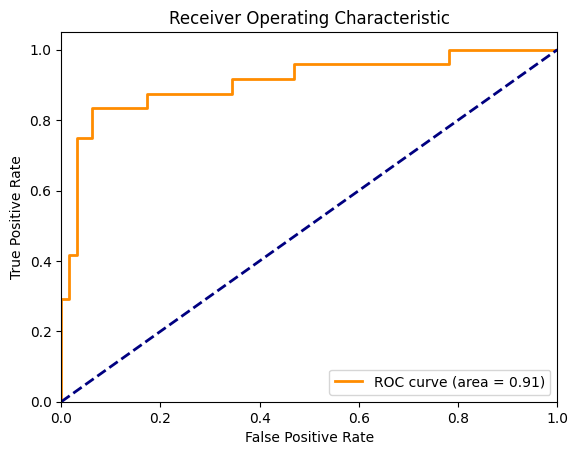

In [7]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv(r"D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_7_features.csv")

# 提取真实标签和预测概率
true_labels = data['True Label']
predicted_probabilities = data['Predicted Probability']

# 计算ROC曲线的参数
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


DCA

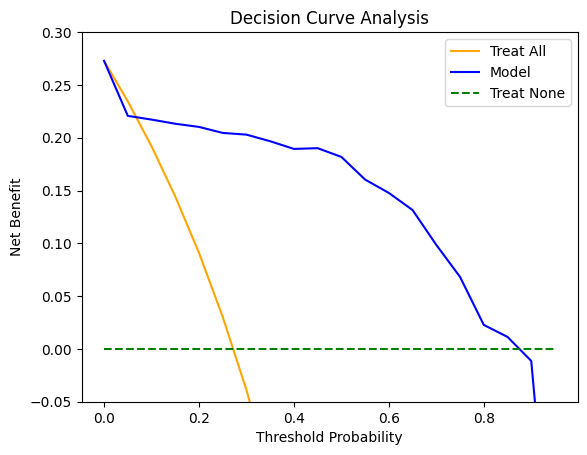

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data_path = r"D:\desktop\B\结果\表格\真实标签和预测概率\internal_true_labels_and_predicted_probabilities_7_features.csv"
data = pd.read_csv(data_path)

# 提取真实标签和预测概率
y_test = data['True Label'].values
y_scores = data['Predicted Probability'].values

# 定义阈值范围
thresh_group = np.arange(0, 1, 0.05)

# 定义计算净收益的函数
def calculate_net_benefit_model(thresholds, predicted_probs, true_labels):
    net_benefits = []
    for threshold in thresholds:
        predicted_labels = (predicted_probs >= threshold).astype(int)
        tp = sum((predicted_labels == 1) & (true_labels == 1))
        fp = sum((predicted_labels == 1) & (true_labels == 0))
        net_benefit = tp / len(true_labels) - fp / len(true_labels) * threshold / (1 - threshold)
        net_benefits.append(net_benefit)
    return np.array(net_benefits)

def calculate_net_benefit_all(thresholds, true_labels):
    net_benefits = []
    prevalence = sum(true_labels) / len(true_labels)
    for threshold in thresholds:
        net_benefit = prevalence - (1 - prevalence) * threshold / (1 - threshold)
        net_benefits.append(net_benefit)
    return np.array(net_benefits)

# 计算模型净收益和整体净收益
net_benefit_model = calculate_net_benefit_model(thresh_group, y_scores, y_test)
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)

# 绘制决策曲线
fig, ax = plt.subplots()

ax.plot(thresh_group, net_benefit_all, label='Treat All', color='orange')  # 红色线
ax.plot(thresh_group, net_benefit_model, label='Model', color='blue')  # 蓝色线在上
ax.plot(thresh_group, np.zeros_like(thresh_group), label='Treat None', linestyle='--', color='green')

# 设置纵轴范围
ax.set_ylim(-0.05, 0.3)

ax.set_xlabel('Threshold Probability')
ax.set_ylabel('Net Benefit')
ax.set_title('Decision Curve Analysis')
ax.legend()

plt.show()


校准曲线

12个特征单独训练

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

# 使用所有的选定特征
selected_features = ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L', 'HR', 'D.Dimer', 'CR', 'age', 'ALT']

# 使用最佳参数
best_params = {
    'activation': 'tanh',
    'alpha': 0.0001,
    'hidden_layer_sizes': (100, 50),
    'learning_rate_init': 0.001,
    'solver': 'adam'
}

# 创建ANN模型实例
model_ann = MLPClassifier(max_iter=500, random_state=RANDOM_SEED, **best_params)

# 训练模型
model_ann.fit(X_train[selected_features], y_train)

# 进行交叉验证预测（训练集和内部验证集）
y_train_pred_cv = cross_val_predict(model_ann, X_train[selected_features], y_train, cv=10, method='predict')
y_train_proba_cv = cross_val_predict(model_ann, X_train[selected_features], y_train, cv=10, method='predict_proba')[:, 1]

y_internal_pred_cv = cross_val_predict(model_ann, X_internal_test[selected_features], y_internal_test, cv=10, method='predict')
y_internal_proba_cv = cross_val_predict(model_ann, X_internal_test[selected_features], y_internal_test, cv=10, method='predict_proba')[:, 1]

# 对外部验证集进行单次预测
y_external_pred_ann = model_ann.predict(X_external_test[selected_features])
y_external_proba_ann = model_ann.predict_proba(X_external_test[selected_features])[:, 1]

# 输出训练集、内部验证集和外部验证集的指标
train_accuracy = accuracy_score(y_train, y_train_pred_cv)
train_precision = precision_score(y_train, y_train_pred_cv, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred_cv, average='weighted')
train_f1 = f1_score(y_train, y_train_pred_cv, average='weighted')
train_auc = roc_auc_score(y_train, y_train_proba_cv)

internal_accuracy = accuracy_score(y_internal_test, y_internal_pred_cv)
internal_precision = precision_score(y_internal_test, y_internal_pred_cv, average='weighted', zero_division=0)
internal_recall = recall_score(y_internal_test, y_internal_pred_cv, average='weighted')
internal_f1 = f1_score(y_internal_test, y_internal_pred_cv, average='weighted')
internal_auc = roc_auc_score(y_internal_test, y_internal_proba_cv)

external_accuracy = accuracy_score(y_external_test, y_external_pred_ann)
external_precision = precision_score(y_external_test, y_external_pred_ann, average='weighted', zero_division=0)
external_recall = recall_score(y_external_test, y_external_pred_ann, average='weighted')
external_f1 = f1_score(y_external_test, y_external_pred_ann, average='weighted')
external_auc = roc_auc_score(y_external_test, y_external_proba_ann)

# 输出结果
print(f"Model with top {len(selected_features)} features: {selected_features}")
print("Best Parameters:", best_params)

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"AUC: {train_auc:.4f}")

print("\nInternal Validation Set Metrics:")
print(f"Accuracy: {internal_accuracy:.4f}")
print(f"Precision: {internal_precision:.4f}")
print(f"Recall: {internal_recall:.4f}")
print(f"F1 Score: {internal_f1:.4f}")
print(f"AUC: {internal_auc:.4f}")

print("\nExternal Validation Set Metrics:")
print(f"Accuracy: {external_accuracy:.4f}")
print(f"Precision: {external_precision:.4f}")
print(f"Recall: {external_recall:.4f}")
print(f"F1 Score: {external_f1:.4f}")
print(f"AUC: {external_auc:.4f}")


Model with top 12 features: ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L', 'HR', 'D.Dimer', 'CR', 'age', 'ALT']
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
Training Set Metrics:
Accuracy: 0.8529
Precision: 0.8510
Recall: 0.8529
F1 Score: 0.8518
AUC: 0.9022

Internal Validation Set Metrics:
Accuracy: 0.8977
Precision: 0.8966
Recall: 0.8977
F1 Score: 0.8970
AUC: 0.9167

External Validation Set Metrics:
Accuracy: 0.8942
Precision: 0.9073
Recall: 0.8942
F1 Score: 0.8835
AUC: 0.8762


7个特征单独训练

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

# 使用所有的选定特征
selected_features = ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L']

# 使用最佳参数
best_params = {
    'activation': 'tanh',
    'alpha': 0.0001,
    'hidden_layer_sizes': (100, 50),
    'learning_rate_init': 0.001,
    'solver': 'adam'
}

# 创建ANN模型实例
model_ann = MLPClassifier(max_iter=500, random_state=RANDOM_SEED, **best_params)

# 训练模型
model_ann.fit(X_train[selected_features], y_train)

# 进行交叉验证预测（训练集和内部验证集）
y_train_pred_cv = cross_val_predict(model_ann, X_train[selected_features], y_train, cv=10, method='predict')
y_train_proba_cv = cross_val_predict(model_ann, X_train[selected_features], y_train, cv=10, method='predict_proba')[:, 1]

y_internal_pred_cv = cross_val_predict(model_ann, X_internal_test[selected_features], y_internal_test, cv=10, method='predict')
y_internal_proba_cv = cross_val_predict(model_ann, X_internal_test[selected_features], y_internal_test, cv=10, method='predict_proba')[:, 1]

# 对外部验证集进行单次预测
y_external_pred_ann = model_ann.predict(X_external_test[selected_features])
y_external_proba_ann = model_ann.predict_proba(X_external_test[selected_features])[:, 1]

# 输出训练集、内部验证集和外部验证集的指标
train_accuracy = accuracy_score(y_train, y_train_pred_cv)
train_precision = precision_score(y_train, y_train_pred_cv, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred_cv, average='weighted')
train_f1 = f1_score(y_train, y_train_pred_cv, average='weighted')
train_auc = roc_auc_score(y_train, y_train_proba_cv)

internal_accuracy = accuracy_score(y_internal_test, y_internal_pred_cv)
internal_precision = precision_score(y_internal_test, y_internal_pred_cv, average='weighted', zero_division=0)
internal_recall = recall_score(y_internal_test, y_internal_pred_cv, average='weighted')
internal_f1 = f1_score(y_internal_test, y_internal_pred_cv, average='weighted')
internal_auc = roc_auc_score(y_internal_test, y_internal_proba_cv)

external_accuracy = accuracy_score(y_external_test, y_external_pred_ann)
external_precision = precision_score(y_external_test, y_external_pred_ann, average='weighted', zero_division=0)
external_recall = recall_score(y_external_test, y_external_pred_ann, average='weighted')
external_f1 = f1_score(y_external_test, y_external_pred_ann, average='weighted')
external_auc = roc_auc_score(y_external_test, y_external_proba_ann)

# 输出结果
print(f"Model with top {len(selected_features)} features: {selected_features}")
print("Best Parameters:", best_params)

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"AUC: {train_auc:.4f}")

print("\nInternal Validation Set Metrics:")
print(f"Accuracy: {internal_accuracy:.4f}")
print(f"Precision: {internal_precision:.4f}")
print(f"Recall: {internal_recall:.4f}")
print(f"F1 Score: {internal_f1:.4f}")
print(f"AUC: {internal_auc:.4f}")

print("\nExternal Validation Set Metrics:")
print(f"Accuracy: {external_accuracy:.4f}")
print(f"Precision: {external_precision:.4f}")
print(f"Recall: {external_recall:.4f}")
print(f"F1 Score: {external_f1:.4f}")
print(f"AUC: {external_auc:.4f}")


Model with top 7 features: ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L']
Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
Training Set Metrics:
Accuracy: 0.8676
Precision: 0.8651
Recall: 0.8676
F1 Score: 0.8661
AUC: 0.8908

Internal Validation Set Metrics:
Accuracy: 0.9091
Precision: 0.9091
Recall: 0.9091
F1 Score: 0.9091
AUC: 0.9069

External Validation Set Metrics:
Accuracy: 0.8654
Precision: 0.8738
Recall: 0.8654
F1 Score: 0.8500
AUC: 0.9034


In [7]:
save_dir = r'D:\desktop\B\结果\表格\ANN真实标签和预测概率（7）'

# 检查文件夹是否存在，如果不存在就创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 获取训练集的真实标签和预测概率
y_train_true = y_train.values
train_data = pd.DataFrame({
    'True_Label': y_train_true,
    'Predicted_Probability': y_train_proba_cv
})
train_data.to_csv(os.path.join(save_dir, 'train_labels_and_probabilities.csv'), index=False)

# 获取内部验证集的真实标签和预测概率
y_internal_true = y_internal_test.values
internal_data = pd.DataFrame({
    'True_Label': y_internal_true,
    'Predicted_Probability': y_internal_proba_cv
})
internal_data.to_csv(os.path.join(save_dir, 'internal_validation_labels_and_probabilities.csv'), index=False)

# 获取外部验证集的真实标签和预测概率
y_external_true = y_external_test.values
external_data = pd.DataFrame({
    'True_Label': y_external_true,
    'Predicted_Probability': y_external_proba_ann
})
external_data.to_csv(os.path.join(save_dir, 'external_validation_labels_and_probabilities.csv'), index=False)

print("训练集、内部验证集和外部验证集的标签和预测概率已保存到指定文件夹。")

训练集、内部验证集和外部验证集的标签和预测概率已保存到指定文件夹。
